In [2]:
#constants
DF_PATH = "../data/processed/1_preprocessed_df.pkl"
ROLES_PATH = "../data/raw/roles_short_names.csv" 

ROLE_COLS      = ['DevType']
TECH_COLS      = ['LanguageWorkedWith',    'DatabaseWorkedWith',    'WebframeWorkedWith',    'MiscTechWorkedWith',   ]
TECH_NEXT_COLS = ['LanguageDesireNextYear','DatabaseDesireNextYear','WebframeDesireNextYear','MiscTechDesireNextYear' ,]


In [3]:
# Load packages
import pandas as pd 
import numpy as np
import logging
import pickle

import plotly 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

import scipy.cluster.hierarchy as sch

# Read data and preprocess

In [4]:
#Read data
raw_df=pd.read_pickle(DF_PATH)
roles_names = pd.read_csv(ROLES_PATH, delimiter=";")


## Onehot enconde


In [5]:
df=raw_df.copy()
encoded_dfs = {}
for col in ROLE_COLS+TECH_COLS:
    binarizer=MultiLabelBinarizer()
    encoded_df=pd.DataFrame(binarizer.fit_transform(df[col]),columns=binarizer.classes_ ,index=df[col].index)
    encoded_dfs[col]=encoded_df    

In [6]:
# Merge 1-hot encoded 
df = pd.concat(encoded_dfs, axis=1)


# Display skills frequency


In [7]:
# Calculate the sum for all cols except Devtypes
skills_freq = df.drop('DevType', axis=1).sum().reset_index()
skills_freq.columns = ['group', 'skill', 'freq']
skills_freq

group                  skill   freq
0   LanguageWorkedWith               Assembly   3553
1   LanguageWorkedWith  Bash/Shell/PowerShell  18980
2   LanguageWorkedWith                      C  12487
3   LanguageWorkedWith                     C#  18041
4   LanguageWorkedWith                    C++  13707
..                 ...                    ...    ...
69  MiscTechWorkedWith               Teraform   2518
70  MiscTechWorkedWith          Torch/PyTorch   1872
71  MiscTechWorkedWith               Unity 3D   4413
72  MiscTechWorkedWith          Unreal Engine   1316
73  MiscTechWorkedWith                Xamarin   2357

[74 rows x 3 columns]

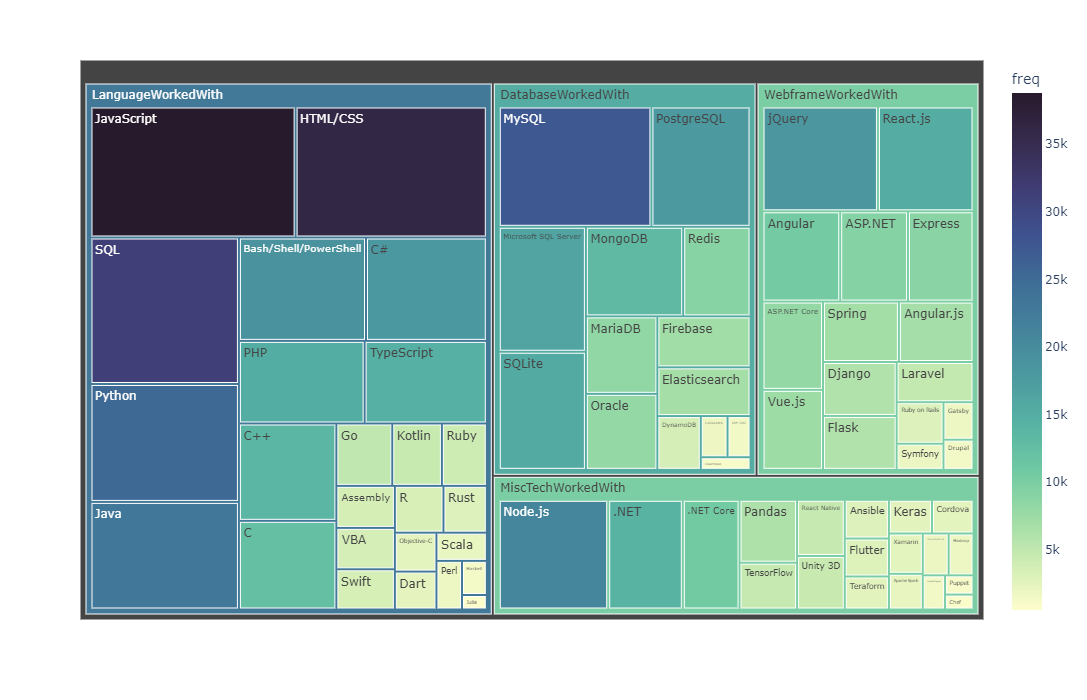

In [8]:
# visulization our skills frequency 
fig=px.treemap(skills_freq, 
                 path=['group', 'skill'], 
                 color_continuous_scale='deep',
                 values='freq',color='freq') 
fig.update_layout(width=1200, height=700)

fig.show()

# Create Jobs & Skills Heatmap

In [9]:
sorted_roles=df['DevType'].sum().sort_values().index.tolist()
sorted_skills=df.drop('DevType', axis=1).sum().sort_values(ascending=False).droplevel(level=0).index.tolist()

In [20]:
skills = []
for role in sorted_roles:
    role_mask = (df[('DevType', role)] == 1)
    skills_role = pd.concat({tech_col: df.loc[role_mask, tech_col].mean() * 100
                             for tech_col in TECH_COLS})
    skills.append(skills_role)
skills = pd.concat(skills, axis=1)


skills.columns = sorted_roles
skills = skills.reset_index(level=0, drop=True)
skills = skills.loc[sorted_skills]

skills = skills.T
skills

JavaScript   HTML/CSS  \
Marketing or sales professional                 71.028037  76.635514   
Senior executive/VP                             72.878788  69.166667   
Engineer, site reliability                      65.876289  58.505155   
Scientist                                       48.465964  47.027804   
Product manager                                 73.007609  69.603524   
Engineering manager                             69.346549  60.682819   
Developer, game or graphics                     67.228397  62.459663   
Educator                                        68.408470  66.803279   
Academic researcher                             54.194820  53.462838   
Engineer, data                                  56.902087  52.594971   
Developer, QA or test                           71.548011  67.240942   
Data scientist or machine learning specialist   48.269809  48.244734   
Data or business analyst                        57.554672  58.971173   
Developer, embedded applications or devices     58.378947  54.105263   
System administrator                            71.041587  69.496375   
Designer                                        75.981958  74.873144   
Database administrator                          74.274729  73.068857   
DevOps specialist                               70.296532  62.707321   
Developer, mobile                               66.642059  60.693946   
Developer, desktop or enterprise applications   65.699253  61.311948   
Developer, front-end                            84.012899  78.312199   
Developer, full-stack                           81.990783  73.784332   
Developer, back-end                             69.391803  61.389011   

                                                     SQL      MySQL  \
Marketing or sales professional                57.788162  61.370717   
Senior executive/VP                            65.075758  49.545455   
Engineer, site reliability                     61.701031  53.762887   
Scientist                                      43.672100  39.213806   
Product manager                                63.115739  52.422907   
Engineering manager                            60.425844  47.099853   
Developer, game or graphics                    49.264970  48.045895   
Educator                                       56.625683  53.859290   
Academic researcher                            46.706081  47.015766   
Engineer, data                                 67.174960  49.678973   
Developer, QA or test                          63.389916  52.520902   
Data scientist or machine learning specialist  58.450351  46.263791   
Data or business analyst                       73.459245  49.652087   
Developer, embedded applications or devices    49.557895  45.031579   
System administrator                           68.141931  57.535292   
Designer                                       58.804736  55.196392   
Database administrator                         80.076896  59.402307   
DevOps specialist                              63.059139  48.433573   
Developer, mobile                              50.284750  50.348028   
Developer, desktop or enterprise applications  62.024779  43.737271   
Developer, front-end                           56.394840  50.841714   
Developer, full-stack                          62.046083  50.226728   
Developer, back-end                            61.374321  49.397679   

                                                  Python       Java  \
Marketing or sales professional                38.629283  32.242991   
Senior executive/VP                            45.984848  33.333333   
Engineer, site reliability                     59.896907  39.948454   
Scientist                                      67.689358  32.981783   
Product manager                                42.010412  36.283540   
Engineering manager                            46.512482  37.995595   
Developer, game or graphics                    43.850843  41.376838   
Educator                                     

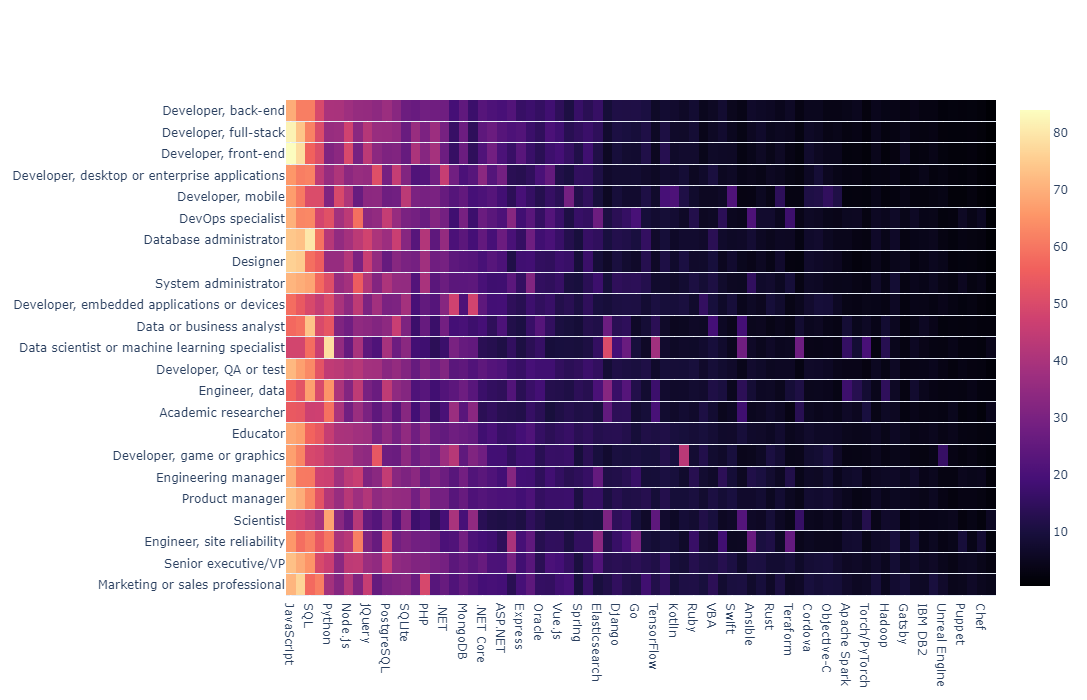

In [11]:
fig = go.Figure(data=go.Heatmap(z=skills, x=skills.columns,y=skills.index, colorscale='magma', ygap=1))
fig.update_layout(width=1200, height=700)
fig.show()


# Create Jobs dendrogram


In [12]:
roles_shorted_dict=roles_names.set_index("Original name")["Short name "].to_dict()
short_labels =[roles_shorted_dict[role] for role in sorted_roles]

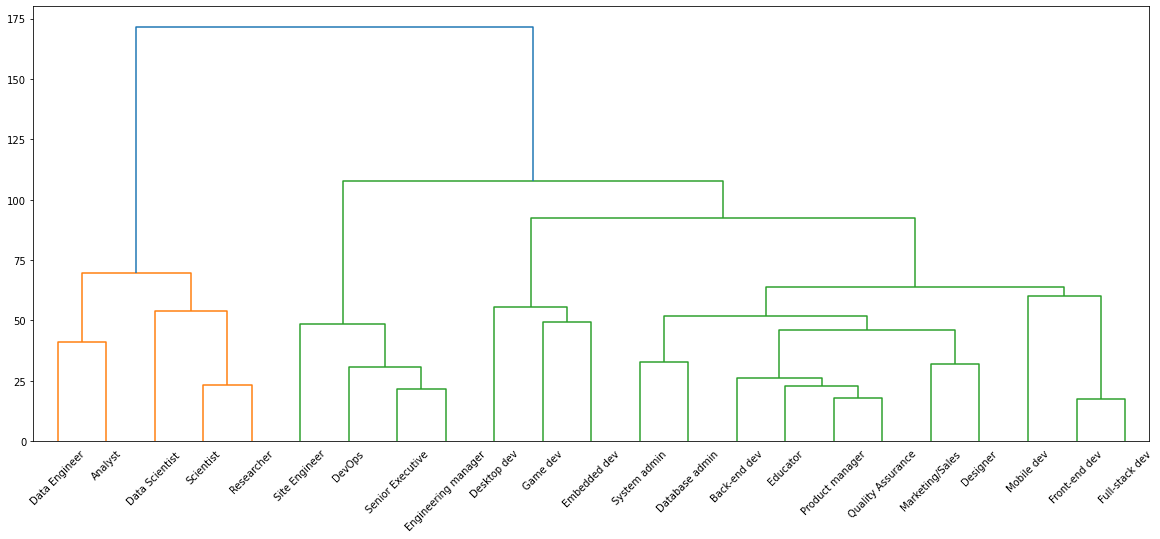

In [13]:
plt.figure(figsize=(20,8))
dendrogram=sch.dendrogram(sch.linkage(skills,method="ward") ,labels=short_labels)

# Normalizing features


In [14]:
std_skills = StandardScaler().fit_transform(skills)
std_skills = pd.DataFrame(std_skills, columns=skills.columns, index=skills.index)
std_skills


JavaScript  HTML/CSS       SQL  \
Marketing or sales professional                  0.433816  1.510025 -0.260708   
Senior executive/VP                              0.636243  0.649598  0.622312   
Engineer, site reliability                      -0.129660 -0.578629  0.213405   
Scientist                                       -2.033926 -1.900843 -1.971116   
Product manager                                  0.650333  0.699925  0.384822   
Engineering manager                              0.249902 -0.327758  0.058894   
Developer, game or graphics                      0.018228 -0.123062 -1.293442   
Educator                                         0.147299  0.377331 -0.401562   
Academic researcher                             -1.407328 -1.159514 -1.603496   
Engineer, data                                  -1.111219 -1.259494  0.876667   
Developer, QA or test                            0.490689  0.427751  0.418043   
Data scientist or machine learning specialist   -2.055381 -1.760650 -0.180472   
Data or business analyst                        -1.039842 -0.524943  1.638119   
Developer, embedded applications or devices     -0.949687 -1.085506 -1.257949   
System administrator                             0.435298  0.687582  0.993833   
Designer                                         0.975655  1.306996 -0.137532   
Database administrator                           0.788925  1.099139  2.439963   
DevOps specialist                                0.353807 -0.094531  0.377964   
Developer, mobile                               -0.045903 -0.326476 -1.169877   
Developer, desktop or enterprise applications   -0.149023 -0.255281  0.252633   
Developer, front-end                             1.854045  1.703182 -0.429533   
Developer, full-stack                            1.632874  1.181563  0.255214   
Developer, back-end                              0.254852 -0.246403  0.173818   

                                                  MySQL    Python      Java  \
Marketing or sales professional                2.216239 -0.766784 -1.369926   
Senior executive/VP                           -0.185986 -0.140330 -1.101400   
Engineer, site reliability                     0.670758  1.044524  0.527746   
Scientist                                     -2.284794  1.708186 -1.187979   
Product manager                                0.398550 -0.478822 -0.374835   
Engineering manager                           -0.682794 -0.095392  0.046803   
Developer, game or graphics                   -0.490612 -0.322077  0.879523   
Educator                                       0.690342 -0.202682  0.538758   
Academic researcher                           -0.699876  0.971301  0.507160   
Engineer, data                                -0.158863  1.486659  0.651127   
Developer, QA or test                          0.418457 -0.291421  1.371552   
Data scientist or machine learning specialist -0.852635  2.614848 -0.677354   
Data or business analyst                      -0.164324  0.476773 -1.654257   
Developer, embedded applications or devices   -1.102951  0.224939  0.498963   
System administrator                           1.437098  0.279616 -0.492209   
Designer                                       0.961965 -0.994810 -0.470398   
Database administrator                         1.816370 -0.459228 -0.681041   
DevOps specialist                             -0.411858  0.352161  0.154255   
Developer, mobile                             -0.022949 -1.399861  2.865545   
Developer, desktop or enterprise applications -1.365881 -0.981491  0.721010   
Developer, front-end                           0.077341 -1.391301 -1.004035   
Developer, full-stack                         -0.047590 -0.973444 -0.252183   
Developer, back-end                           -0.216006 -0.661366  0.503175   

                                                Node.js  \
Marketing or sales professional                0.528826   
Senior executive/VP                            0.843117   
Engineer, site reliability  

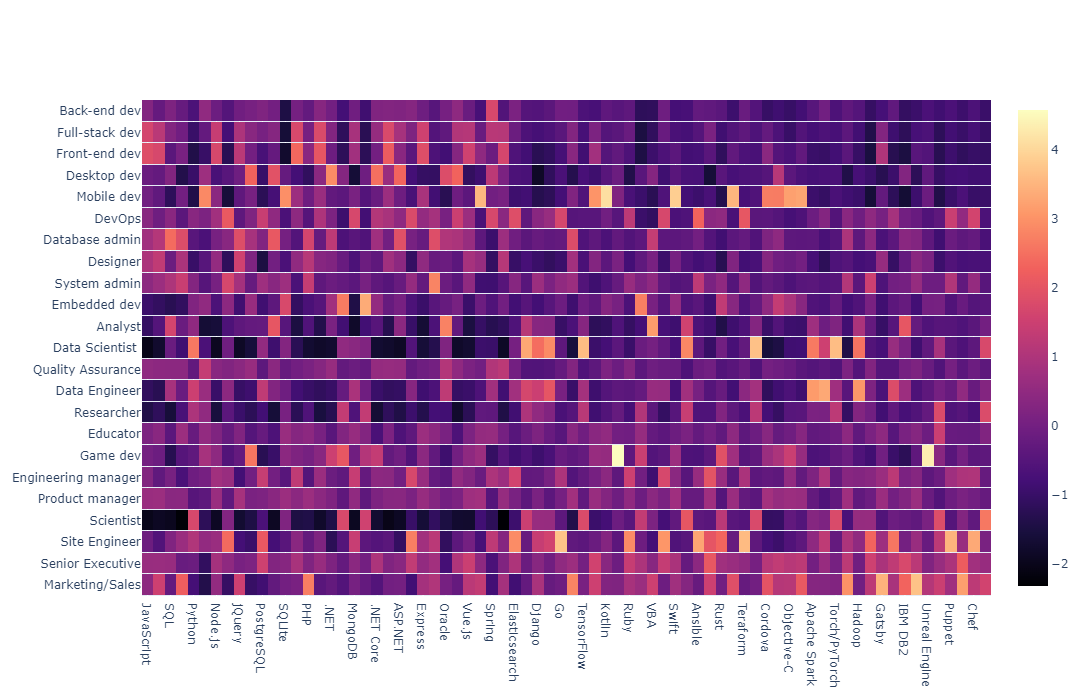

In [15]:
#visualize skills after normalization
fig = go.Figure(data=go.Heatmap(z=std_skills, x=skills.columns,y=short_labels , colorscale='magma', ygap=1))
fig.update_layout(width=1200, height=700)
fig.show()


In [16]:
sorted_roles

['Marketing or sales professional',
 'Senior executive/VP',
 'Engineer, site reliability',
 'Scientist',
 'Product manager',
 'Engineering manager',
 'Developer, game or graphics',
 'Educator',
 'Academic researcher',
 'Engineer, data',
 'Developer, QA or test',
 'Data scientist or machine learning specialist',
 'Data or business analyst',
 'Developer, embedded applications or devices',
 'System administrator',
 'Designer',
 'Database administrator',
 'DevOps specialist',
 'Developer, mobile',
 'Developer, desktop or enterprise applications',
 'Developer, front-end',
 'Developer, full-stack',
 'Developer, back-end']

# Job profiles


In [17]:
# role = np.random.choice(sorted_roles)
role = 'Data scientist or machine learning specialist'
single_role_skills = pd.concat([skills.loc[role], std_skills.loc[role]], axis=1)
single_role_skills.columns = ['percentage', 'specificity']
single_role_skills = single_role_skills.sort_values('percentage')
single_role_skills

percentage  specificity
Chef             2.081244    -0.366560
Couchbase        2.357071    -0.627059
Puppet           2.432297    -0.425910
Gatsby           2.683049    -0.732300
Unreal Engine    2.758275    -0.330042
...                   ...          ...
HTML/CSS        48.244734    -1.760650
JavaScript      48.269809    -2.055381
Pandas          50.075226     3.291584
SQL             58.450351    -0.180472
Python          78.335005     2.614848

[74 rows x 2 columns]

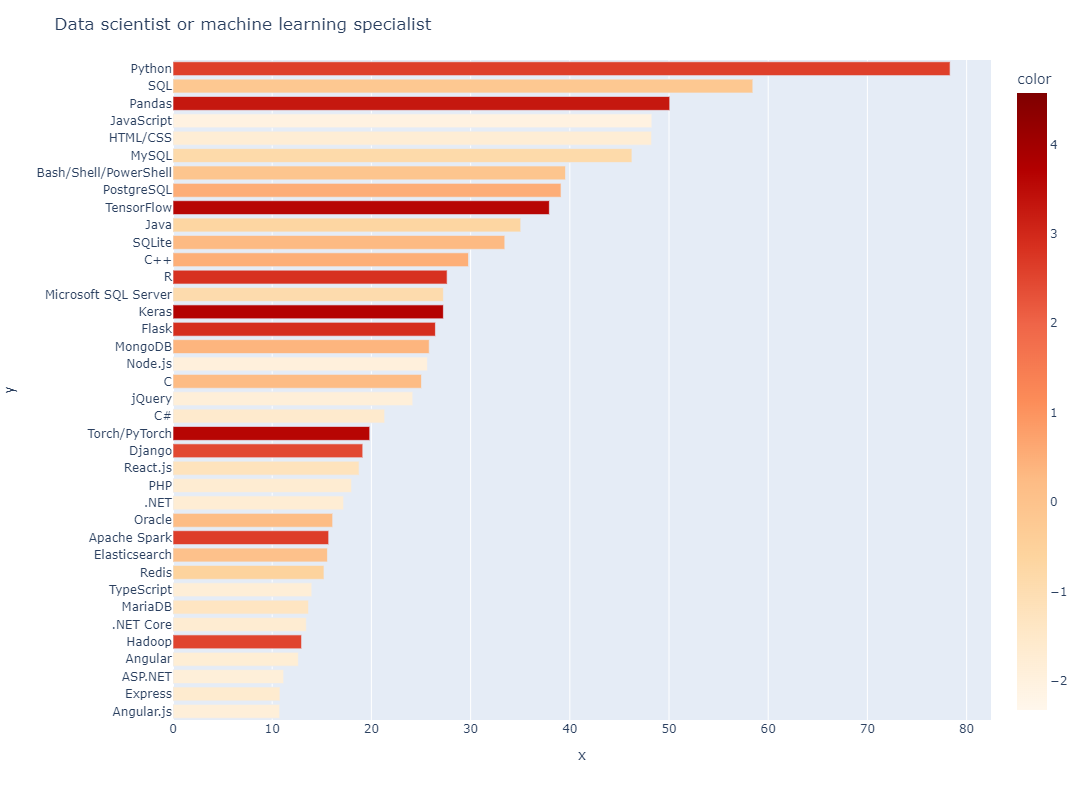

In [18]:
threshold = 10

single_role_skills = single_role_skills[single_role_skills['percentage'] > threshold]

fig = px.bar(df, 
             y=single_role_skills.index, 
             x=single_role_skills['percentage'], 
             color=single_role_skills['specificity'], 
             color_continuous_scale='orrd', 
             range_color=[std_skills.values.min(),std_skills.values.max()],
             orientation='h')

fig.update_layout(width=800, height=800, title=role)
fig.show()

In [19]:
single_role_skills.sort_values("specificity" ,ascending=False)

percentage  specificity
Keras                   27.256770     3.681277
Torch/PyTorch           19.834504     3.622534
TensorFlow              37.938816     3.610934
Pandas                  50.075226     3.291584
Flask                   26.454363     2.894423
R                       27.632899     2.836607
Apache Spark            15.697091     2.645619
Python                  78.335005     2.614848
Hadoop                  12.963892     2.526671
Django                  19.132397     2.457619
PostgreSQL              39.117352     0.531237
C++                     29.789368     0.497305
MongoDB                 25.827482     0.386082
SQLite                  33.450351     0.279996
C                       25.050150     0.215324
Oracle                  16.098295     0.195945
Elasticsearch           15.571715     0.046066
Bash/Shell/PowerShell   39.568706    -0.078961
SQL                     58.450351    -0.180472
Redis                   15.220662    -0.558675
Java                    35.055165    -0.677354
MySQL                   46.263791    -0.852635
Microsoft SQL Server    27.256770    -0.900649
React.js                18.756269    -1.238718
MariaDB                 13.665998    -1.332922
C#                      21.339017    -1.585191
Express                 10.782347    -1.626968
PHP                     18.004012    -1.706062
.NET Core               13.440321    -1.708663
.NET                    17.201605    -1.743318
HTML/CSS                48.244734    -1.760650
Angular                 12.637914    -1.777427
TypeScript              13.991976    -1.811202
jQuery                  24.172518    -1.861257
Angular.js              10.757272    -1.871586
ASP.NET                 11.158475    -1.874537
Node.js                 25.651956    -1.946425
JavaScript              48.269809    -2.055381